In [6]:
# 구글 드라이버 이용
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#필요 라이브러리 임포트
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
plt.rcParams['axes.unicode_minus'] = False
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import math as m

In [0]:
# 파일 불러오기 예시
# pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv')

# 4319
train_dt = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train.csv').set_index('id')
test_dt = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/test.csv').set_index('id')

### 분석 방법

1. Y00 - Y17 4300개의 데이터로 각 feature 430개의 값을 예측 
    - Y18 값과 유사한 feature 찾기
    - Y06,Y09,Y12,Y16이 Y18과의 mse값이 낮고, 상관도가 높다.

2. Y06,Y09,Y12,Y16의 조합으로 진짜 Y18을 예측
    - mse가 가장 낮은 조합을 사용

3.  Y_train 값 설정
  - 2번의 조합 + 기존의 Y18로 나머지 test 예측
  - 2번의 조합에서 각각의 Y로 80일 예측 후 평균

4. feature 공학

In [0]:
def predict_test(X_train, y_train, X_test):

  lgb_train = lgb.Dataset(X_train, label=y_train)

  lgb_param = {
      "objective":"regression",
      "metrics":"mae",
      "learning_rate":0.05
  }

  print("cv start")
  cv_result = lgb.cv(
      lgb_param,
      lgb_train,
      num_boost_round=99999,
      nfold=5,
      early_stopping_rounds=30,
      stratified=False,
      verbose_eval=10 
  )

  print("train start")
  lgb_model = lgb.train(
      lgb_param,
      lgb_train,
      num_boost_round=len(cv_result["l1-mean"])
  )

  pred = lgb_model.predict(X_test)

  feature_importance = pd.DataFrame({'name' : lgb_model.feature_name(),
                                   'importance' : lgb_model.feature_importance()})\
                                   .sort_values(by = 'importance', ascending = False)
  
  return pred, feature_importance

In [0]:
X_train = train_dt.iloc[:4320, :40]
X_test = train_dt.iloc[4320:, :40]
X = train_dt.iloc[:, :40]
Y_train = train_dt.loc[:4319, ['Y06','Y09','Y12']].mean(axis = 1)
Y_test = train_dt.loc[4320:, ['Y18']]

In [0]:
# # data_processing_lst = []
# # data_processing_lst 불러오기
# data_processing_lst = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data_processing_lst.csv').values.tolist()
# data_processing_lst

In [0]:
# data_processing = []

In [0]:
### Best Processing

def data_processing(X_data):
  X_data['X01'] = X_data[['X01','X06']].mean(axis = 1)
  X_data['X22'] = X_data[['X22','X29']].mean(axis = 1)
  X_data['X05'] = X_data[['X05','X08','X09','X23','X33']].mean(axis = 1)
  X_data['X11'] = X_data[['X11','X34']].mean(axis = 1)
  # 13 삭제 / 14,16,19 0 값 삭제
  X_data = X_data.drop(['X06','X29','X08','X09','X23','X33','X34','X13','X14','X16','X19'], axis = 1)
  return X_data

In [0]:
# from sklearn.preprocessing import FunctionTransformer

# def data_processing1(X_data):
#   # 풍향 North_South / East_West
#   X_data['North_South_X13'] = X['X13'].apply(lambda x : m.sin(m.radians(x)))
#   X_data['East_West_X13'] = X['X13'].apply(lambda x : m.cos(m.radians(x)))

#   X_data['North_South_X15'] = X['X15'].apply(lambda x : m.sin(m.radians(x)))
#   X_data['East_West_X15'] = X['X15'].apply(lambda x : m.cos(m.radians(x)))

#   X_data['North_South_X17'] = X['X17'].apply(lambda x : m.sin(m.radians(x)))
#   X_data['East_West_X17'] = X['X17'].apply(lambda x : m.cos(m.radians(x)))

#   X_data['North_South_X25'] = X['X25'].apply(lambda x : m.sin(m.radians(x)))
#   X_data['East_West_X25'] = X['X25'].apply(lambda x : m.cos(m.radians(x)))

#   X_data['North_South_X35'] = X['X35'].apply(lambda x : m.sin(m.radians(x)))
#   X_data['East_West_X35'] = X['X35'].apply(lambda x : m.cos(m.radians(x)))

#   # 누적 일사량 평균
#   X_data['Mean_cumulative_daily_insolation'] = X_data[['X11','X34']].mean(axis = 1)
#   # 풍속 평균
#   X_data['Mean_wind_speed'] = X_data[['X02','X03','X18','X24','X26']].mean(axis = 1)
#   # 풍향 평균
#   X_data['Mean_North_South'] = X_data[['North_South_X13','North_South_X15','North_South_X17','North_South_X25','North_South_X35']].mean(axis = 1)
#   X_data['Mean_East_West'] = X_data[['East_West_X13','East_West_X15','East_West_X17','East_West_X25','East_West_X35']].mean(axis = 1)

#   # 풍향 * 풍속
#   # X_data['North_South_wind_speed'] = X_data['Mean_North_South'] * X_data['Mean_wind_speed']
#   # X_data['East_West_wind_speed'] = X_data['Mean_North_South'] * X_data['Mean_wind_speed']

#   # 현지 기압 삭제
#   X_data = X_data.drop(['X01','X06','X22','X27','X29'], axis = 1)
#   # 풍속 삭제
#   X_data = X_data.drop(['X02','X03','X18','X24','X26'], axis = 1)
#   # 누적 강수량 삭제
#   X_data = X_data.drop(['X04','X10','X21','X36','X39'], axis = 1)
#   # 해면 기압 삭제
#   X_data = X_data.drop(['X05','X08','X09','X23','X33'], axis = 1)
#   # 누적 일사량 삭제
#   X_data = X_data.drop(['X11','X14','X16','X19','X34'], axis = 1)
#   # 풍향 삭제
#   X_data = X_data.drop(['X13','X15','X17','X25','X35'], axis = 1)
#   X_data = X_data.drop(['North_South_X13','North_South_X15','North_South_X17','North_South_X25','North_South_X35'], axis = 1)
#   X_data = X_data.drop(['East_West_X13','East_West_X15','East_West_X17','East_West_X25','East_West_X35'], axis = 1)

#   return X_data

# new_X = data_processing1(X.copy())
# X_train = new_X.iloc[:4320, :40]
# X_test = new_X.iloc[4320:, :40]
# Y_pred, feature_importance = predict_test(X_train, Y_train, X_test)

In [0]:
# Y_combination = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Y_conbination_lst.csv').values.tolist()
# Y_combination

In [320]:
data_processing = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data_processing.csv').values.tolist()
data_processing

[['Basic2_Y060912_drop_mean_temp_humidity', 3.647894837976495],
 ['Basic2', 3.647894837976495],
 ['Basic1_drop_plus_temp_humidity', 3.647894837976495],
 ['Basic2_Y060912', 3.6513267182311018],
 ['Basic2', 3.6513267182311018],
 ['Basic1_Y060912_drop_plus_temp_humidity', 3.6513267182311018],
 ['Basic2', 3.772853767942077],
 ['Basic2_Y060912_Mean_temp_humidity', 3.784112767312618],
 ['Basic1_drop_plus_temp_humidity', 3.907666617031032],
 ['Basic1_mean_temp_drop_temp', 4.253730398019279],
 ['Basic1_mean_temp_humidity_drop_temp_humidity_plus_temp_humidity',
  4.35017281034993],
 ['Basic1_mean_temp_humidity_drop_temp_humidity_plus_temp_humidity',
  4.35017281034993],
 ['Basic1_mean_temp_humidity_drop_temp_humidity_plus_temp_humidity',
  4.35017281034993],
 ['Best_plus_NS_EW_min', 4.369218495377544],
 ['Best_plus_NS_EW_min_Mean_CumRain', 4.409326212426367],
 ['Best_plus_NS_EW_min_Mean_CumRain', 4.409515915693611],
 ['Basic_plus_min_cos', 4.5591880488118575],
 ['Basic1_mean_temp_humidity_drop_

In [0]:
# lst = [['Y06'], ['Y09'], ['Y12'], ['Y16'], ['Y06', 'Y09'], ['Y06', 'Y12'], ['Y06', 'Y16'], ['Y09', 'Y12'], ['Y09', 'Y16'], ['Y12', 'Y16'], ['Y06', 'Y09', 'Y12'], ['Y06', 'Y09', 'Y16'], ['Y06', 'Y12', 'Y16'], ['Y09', 'Y12', 'Y16'], ['Y06', 'Y09', 'Y12', 'Y16']]

# for i in lst:
#   # N = i.append(['Y15'])
#   # print(N)
#   tmp = i + ['Y15']
#   print(tmp)

In [0]:
# lst = [['Y06'], ['Y09'], ['Y12'], ['Y16'], ['Y06', 'Y09'], ['Y06', 'Y12'], ['Y06', 'Y16'], ['Y09', 'Y12'], ['Y09', 'Y16'], ['Y12', 'Y16'], ['Y06', 'Y09', 'Y12'], ['Y06', 'Y09', 'Y16'], ['Y06', 'Y12', 'Y16'], ['Y09', 'Y12', 'Y16'], ['Y06', 'Y09', 'Y12', 'Y16']]

# for Y in lst:
#   print(Y)s
#   # Y = ['Y12', 'Y16']

#   X_train = train_dt.iloc[:4320, :40]
#   X_test = train_dt.iloc[4320:, :40]
#   X = train_dt.iloc[:, :40]
#   Y_train = train_dt.loc[:4319, Y].mean(axis = 1)
#   Y_test = train_dt.loc[4320:, ['Y18']]


#   new_X = data_processing1(X.copy())
#   X_train = new_X.iloc[:4320, :40]
#   X_test = new_X.iloc[4320:, :40]
#   Y_pred, feature_importance = predict_test(X_train, Y_train, X_test)


#   Y_test.index = range(len(Y_pred))
#   plt.plot(Y_pred)
#   plt.plot(Y_test['Y18'])
#   mse = ((Y_pred - np.array(Y_test['Y18']))**2).sum()
#   # data_processing_lst.append(['Drop___daily_cumulative_precipitation___local_air_pressure___barometric_pressure___cumulative_daily_insolation___wind_speed___Mean_wind_speed___wind_direction___North_South___East_West___Mean_cumulative_daily_insolation___wind_speed___North_South___East_West___Processing_wind_direction___wind_direction*wind_speed',mse])
#   Y_combination.append([Y,mse])
#   print(mse)
#   print(feature_importance)

In [0]:
# Y_conbination_lst = pd.DataFrame(Y_combination, columns = ['name','mse']).set_index('name').sort_values('mse')
# Y_conbination_lst.to_csv('/content/gdrive/My Drive/Colab Notebooks/Y_conbination_lst.csv')
# Y_conbination_lst.head(15)

In [0]:
## Basic 2

from sklearn.preprocessing import FunctionTransformer

def data_processing1(X_data):
  # 풍향 North_South / East_West
  X_data['North_South_X13'] = X['X13'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X13'] = X['X13'].apply(lambda x : m.cos(m.radians(x)))

  X_data['North_South_X15'] = X['X15'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X15'] = X['X15'].apply(lambda x : m.cos(m.radians(x)))

  X_data['North_South_X17'] = X['X17'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X17'] = X['X17'].apply(lambda x : m.cos(m.radians(x)))

  X_data['North_South_X25'] = X['X25'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X25'] = X['X25'].apply(lambda x : m.cos(m.radians(x)))

  X_data['North_South_X35'] = X['X35'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X35'] = X['X35'].apply(lambda x : m.cos(m.radians(x)))

  # 누적 일사량 평균
  X_data['Mean_cumulative_daily_insolation'] = X_data[['X11','X34']].mean(axis = 1)
  # 풍속 평균
  X_data['Mean_wind_speed'] = X_data[['X02','X03','X18','X24','X26']].mean(axis = 1)
  # 풍향 평균
  X_data['Mean_North_South'] = X_data[['North_South_X13','North_South_X15','North_South_X17','North_South_X25','North_South_X35']].mean(axis = 1)
  X_data['Mean_East_West'] = X_data[['East_West_X13','East_West_X15','East_West_X17','East_West_X25','East_West_X35']].mean(axis = 1)
  # 평균 기온
  X_data['Mean_temp'] = X_data[['X00','X07','X28','X31','X32']].mean(axis = 1)
  # 평균 습도
  X_data['Mean_humidity'] = X_data[['X12','X20','X30','X37','X38']].mean(axis = 1)

  # 풍향 * 풍속
  X_data['North_South_wind_speed'] = X_data['Mean_North_South'] * X_data['Mean_wind_speed']
  X_data['East_West_wind_speed'] = X_data['Mean_East_West'] * X_data['Mean_wind_speed']
  
  # 기온 * 습도
  X_data['Mean_humidity'] = X_data['Mean_humidity'].apply(lambda x : x / 100) # list(map(lambda x : x / 100, X_data['Mean_humidity']))
  X_data['Temp_Humidity'] = X_data['Mean_humidity'] * X_data['Mean_temp']

  # 시간
  X_data['min'] = pd.Series((new_X.index%144)/144*360).apply(lambda x : m.cos(m.radians(x)))

  # 습도 삭제
  # X_data = X_data.drop(['X12','X20','X30','X37','X38'], axis = 1)
  # 기온 삭제
  # X_data = X_data.drop(['X00','X07','X28','X31','X32'], axis = 1)
  X_data = X_data.drop(['Mean_humidity','Mean_temp'], axis = 1)
  # 현지 기압 삭제
  X_data = X_data.drop(['X01','X06','X22','X27','X29'], axis = 1)
  # 풍속 삭제
  X_data = X_data.drop(['X02','X03','X18','X24','X26'], axis = 1)
  # 누적 강수량 삭제
  X_data = X_data.drop(['X04','X10','X21','X36','X39'], axis = 1)
  # 해면 기압 삭제
  X_data = X_data.drop(['X05','X08','X09','X23','X33'], axis = 1)
  # 누적 일사량 삭제
  X_data = X_data.drop(['X11','X14','X16','X19','X34'], axis = 1)
  # 풍향 삭제
  X_data = X_data.drop(['X13','X15','X17','X25','X35'], axis = 1)
  X_data = X_data.drop(['North_South_X13','North_South_X15','North_South_X17','North_South_X25','North_South_X35'], axis = 1)
  X_data = X_data.drop(['East_West_X13','East_West_X15','East_West_X17','East_West_X25','East_West_X35'], axis = 1)
  # 파생변수 삭제
  X_data = X_data.drop(['Mean_North_South','Mean_East_West','Mean_wind_speed'], axis = 1)

  return X_data

new_X = data_processing1(X.copy())
X_train = new_X.iloc[:4320, :40]
X_test = new_X.iloc[4320:, :40]
Y_pred, feature_importance = predict_test(X_train, Y_train, X_test)

In [0]:
from sklearn.preprocessing import FunctionTransformer

def data_processing1(X_data):
  # 풍향 North_South / East_West
  X_data['North_South_X13'] = X['X13'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X13'] = X['X13'].apply(lambda x : m.cos(m.radians(x)))

  X_data['North_South_X15'] = X['X15'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X15'] = X['X15'].apply(lambda x : m.cos(m.radians(x)))

  X_data['North_South_X17'] = X['X17'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X17'] = X['X17'].apply(lambda x : m.cos(m.radians(x)))

  X_data['North_South_X25'] = X['X25'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X25'] = X['X25'].apply(lambda x : m.cos(m.radians(x)))

  X_data['North_South_X35'] = X['X35'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X35'] = X['X35'].apply(lambda x : m.cos(m.radians(x)))

  # 누적 일사량 평균
  X_data['Mean_cumulative_daily_insolation'] = X_data[['X11','X34']].mean(axis = 1)
  # 풍속 평균
  X_data['Mean_wind_speed'] = X_data[['X02','X03','X18','X24','X26']].mean(axis = 1)
  # 풍향 평균
  X_data['Mean_North_South'] = X_data[['North_South_X13','North_South_X15','North_South_X17','North_South_X25','North_South_X35']].mean(axis = 1)
  X_data['Mean_East_West'] = X_data[['East_West_X13','East_West_X15','East_West_X17','East_West_X25','East_West_X35']].mean(axis = 1)
  # 평균 기온
  X_data['Mean_temp'] = X_data[['X00','X07','X28','X31','X32']].mean(axis = 1)
  # 평균 습도
  X_data['Mean_humidity'] = X_data[['X12','X20','X30','X37','X38']].mean(axis = 1)

  # 풍향 * 풍속
  X_data['North_South_wind_speed'] = X_data['Mean_North_South'] * X_data['Mean_wind_speed']
  X_data['East_West_wind_speed'] = X_data['Mean_East_West'] * X_data['Mean_wind_speed']
  
  # 기온 * 습도
  # X_data['Mean_humidity'] = X_data['Mean_humidity'].apply(lambda x : x / 100) # list(map(lambda x : x / 100, X_data['Mean_humidity']))
  # X_data['Temp_Humidity'] = X_data['Mean_humidity'] * X_data['Mean_temp']

  # 시간
  X_data['min'] = pd.Series((new_X.index%144)/144*360).apply(lambda x : m.cos(m.radians(x)))

  # 습도 삭제
  # X_data = X_data.drop(['X12','X20','X30','X37','X38'], axis = 1)
  # 기온 삭제
  # X_data = X_data.drop(['X00','X07','X28','X31','X32'], axis = 1)
  X_data = X_data.drop(['Mean_humidity','Mean_temp'], axis = 1)
  # 현지 기압 삭제
  X_data = X_data.drop(['X01','X06','X22','X27','X29'], axis = 1)
  # 풍속 삭제
  X_data = X_data.drop(['X02','X03','X18','X24','X26'], axis = 1)
  # 누적 강수량 삭제
  X_data = X_data.drop(['X04','X10','X21','X36','X39'], axis = 1)
  # 해면 기압 삭제
  X_data = X_data.drop(['X05','X08','X09','X23','X33'], axis = 1)
  # 누적 일사량 삭제
  X_data = X_data.drop(['X11','X14','X16','X19','X34'], axis = 1)
  # 풍향 삭제
  X_data = X_data.drop(['X13','X15','X17','X25','X35'], axis = 1)
  X_data = X_data.drop(['North_South_X13','North_South_X15','North_South_X17','North_South_X25','North_South_X35'], axis = 1)
  X_data = X_data.drop(['East_West_X13','East_West_X15','East_West_X17','East_West_X25','East_West_X35'], axis = 1)
  # 파생변수 삭제
  X_data = X_data.drop(['Mean_North_South','Mean_East_West','Mean_wind_speed'], axis = 1)

  return X_data

new_X = data_processing(X.copy())
X_train = new_X.iloc[:4320, :40]
X_test = new_X.iloc[4320:, :40]
Y_pred, feature_importance = predict_test(X_train, Y_train, X_test)

In [0]:
### Best Processing
X_train = train_dt.iloc[:4320, :40]
X_test = train_dt.iloc[4320:, :40]
X = train_dt.iloc[:, :40]
Y_train = train_dt.loc[:4319, ['Y06','Y09','Y12']].mean(axis = 1)
Y_test = train_dt.loc[4320:, ['Y18']]

def data_processing_(X_data):
  # 풍향 North_South / East_West
  # X13은 영향이 없다고 판단
  X_data['North_South_X15'] = X['X15'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X15'] = X['X15'].apply(lambda x : m.cos(m.radians(x)))

  X_data['North_South_X17'] = X['X17'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X17'] = X['X17'].apply(lambda x : m.cos(m.radians(x)))

  X_data['North_South_X25'] = X['X25'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X25'] = X['X25'].apply(lambda x : m.cos(m.radians(x)))

  X_data['North_South_X35'] = X['X35'].apply(lambda x : m.sin(m.radians(x)))
  X_data['East_West_X35'] = X['X35'].apply(lambda x : m.cos(m.radians(x)))

  # 시간
  # X_data['min'] = pd.Series((new_X.index%144)/144*360).apply(lambda x : m.sin(m.radians(x)))

  # 현지 기압 평균
  X_data['Mean_01_06'] = X_data[['X01','X06']].mean(axis = 1)
  X_data['Mean_22_29'] = X_data[['X22','X29']].mean(axis = 1)
  # 해면 기압 평균
  X_data['Mean_05_08_09_23_33'] = X_data[['X05','X08','X09','X23','X33']].mean(axis = 1)
  # 누적 일사량 평균
  X_data['Mean_11_34'] = X_data[['X11','X34']].mean(axis = 1)
  
  # 풍향 삭제
  X_data = X_data.drop(['X13','X15','X17','X25','X35'], axis = 1)
  # 현지 기압 삭제
  X_data = X_data.drop(['X01','X06','X22','X29'], axis = 1)
  # 해면 기압 삭제
  X_data = X_data.drop(['X05','X08','X09','X23','X33'], axis = 1)
  # 누적 일사량 삭제
  X_data = X_data.drop(['X11','X14','X16','X19','X34'], axis = 1)

  return X_data


#   ### Best Processing

# def data_processing(X_data):
#   X_data['X01'] = X_data[['X01','X06']].mean(axis = 1)
#   X_data['X22'] = X_data[['X22','X29']].mean(axis = 1)
#   X_data['X05'] = X_data[['X05','X08','X09','X23','X33']].mean(axis = 1)
#   X_data['X11'] = X_data[['X11','X34']].mean(axis = 1)
#   # 13 삭제 / 14,16,19 0 값 삭제
#   X_data = X_data.drop(['X06','X29','X08','X09','X23','X33','X34','X13','X14','X16','X19'], axis = 1)
#   return X_data

In [327]:
new_X = data_processing_(X.copy())
X_train = new_X.iloc[:4320, :40]
X_test = new_X.iloc[4320:, :40]
Y_pred, feature_importance = predict_test(X_train, Y_train, X_test)

cv start
[10]	cv_agg's l1: 4.33694 + 0.0431741
[20]	cv_agg's l1: 2.73201 + 0.0246743
[30]	cv_agg's l1: 1.81272 + 0.0159636
[40]	cv_agg's l1: 1.29773 + 0.0144609
[50]	cv_agg's l1: 1.02079 + 0.0205674
[60]	cv_agg's l1: 0.869021 + 0.0187278
[70]	cv_agg's l1: 0.78076 + 0.0204232
[80]	cv_agg's l1: 0.725851 + 0.0180357
[90]	cv_agg's l1: 0.69005 + 0.0170166
[100]	cv_agg's l1: 0.661632 + 0.0169534
[110]	cv_agg's l1: 0.641391 + 0.016646
[120]	cv_agg's l1: 0.625346 + 0.017387
[130]	cv_agg's l1: 0.613121 + 0.0180513
[140]	cv_agg's l1: 0.603478 + 0.018413
[150]	cv_agg's l1: 0.595451 + 0.0189785
[160]	cv_agg's l1: 0.588145 + 0.0188282
[170]	cv_agg's l1: 0.581544 + 0.0186277
[180]	cv_agg's l1: 0.575884 + 0.0183207
[190]	cv_agg's l1: 0.570783 + 0.0175358
[200]	cv_agg's l1: 0.565811 + 0.0171102
[210]	cv_agg's l1: 0.561578 + 0.0174636
[220]	cv_agg's l1: 0.558074 + 0.017546
[230]	cv_agg's l1: 0.554442 + 0.017727
[240]	cv_agg's l1: 0.551563 + 0.0177912
[250]	cv_agg's l1: 0.548728 + 0.0181102
[260]	cv_agg

6.263948885194136
                   name  importance
28        East_West_X35        3315
6                   X12        3241
22        East_West_X15        3216
27      North_South_X35        3215
32           Mean_11_34        3143
21      North_South_X15        3053
19                  X38        2965
14                  X30        2879
8                   X20        2839
16                  X32        2803
24        East_West_X17        2775
18                  X37        2701
0                   X00        2693
23      North_South_X17        2685
15                  X31        2603
1                   X02        2566
2                   X03        2467
7                   X18        2438
4                   X07        2368
13                  X28        2197
11                  X26        2165
12                  X27        2030
25      North_South_X25        1859
29           Mean_01_06        1818
26        East_West_X25        1751
10                  X24        1694
30        

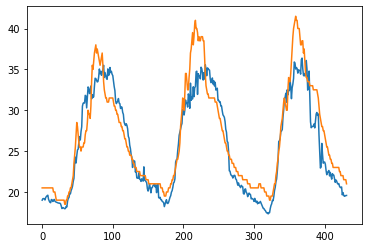

In [328]:
# Basic : Y06,Y12 / Basic model
# Basic1 : Y06,Y12 / Basic model + min(cos)
# Basic2 : Y06,Y12 / Basic model
Y_test.index = range(len(Y_pred))
plt.plot(Y_pred)
plt.plot(Y_test['Y18'])
mse = (np.array(list(map(lambda x : 0 if x <= 1 and x >= -1 else x, (Y_pred - np.array(Y_test['Y18']))))) ** 2).mean()
# data_processing_lst.append(['Drop___daily_cumulative_precipitation___local_air_pressure___barometric_pressure___cumulative_daily_insolation___wind_speed___Mean_wind_speed___wind_direction___North_South___East_West___Mean_cumulative_daily_insolation___wind_speed___North_South___East_West___Processing_wind_direction___wind_direction*wind_speed',mse])
data_processing.append(['Best_plus_NS_EW_min',mse])
# Y_combination.append([Y,mse])
print(mse)
print(feature_importance)

In [329]:
result = pd.DataFrame(data_processing, columns = ['name','mse']).set_index('name').sort_values('mse')
result.to_csv('/content/gdrive/My Drive/Colab Notebooks/data_processing.csv')
result

,mse
name,
Basic2_Y060912_drop_mean_temp_humidity,3.647895
Basic2,3.647895
Basic1_drop_plus_temp_humidity,3.647895
Basic2_Y060912,3.651327
Basic2,3.651327
Basic1_Y060912_drop_plus_temp_humidity,3.651327
Basic2,3.772854
Basic2_Y060912_Mean_temp_humidity,3.784113
Basic1_drop_plus_temp_humidity,3.907667


In [0]:
# Y_conbination_lst = pd.DataFrame(Y_combination, columns = ['name','mse']).set_index('name').sort_values('mse')
# Y_conbination_lst.to_csv('/content/gdrive/My Drive/Colab Notebooks/Y_conbination_lst.csv')
# Y_conbination_lst.head(15)

In [0]:
# result = pd.DataFrame(data_processing_lst, columns = ['name','mse']).set_index('name').sort_values('mse')
# result.to_csv('/content/gdrive/My Drive/Colab Notebooks/data_processing_lst.csv')
# result.head(15)

In [201]:
test_dt.shape

(11520, 40)

In [202]:
X.shape

(4752, 40)

In [330]:
Y_combination = ['Y06','Y09','Y12']

X_train = train_dt.iloc[:4320, :40]
X_test = train_dt.iloc[4320:, :40]
X = train_dt.iloc[:, :40]
Y_train = train_dt.loc[:4319, Y_combination].mean(axis = 1)
Y_test = train_dt.loc[4320:, ['Y18']]

# 4300개의 예측값 + Y_의 실제값
before = train_dt[Y_combination].iloc[:-432].mean(axis = 1)
# after = main[[18]].mean(axis = 1)
after = train_dt.iloc[4320:,-1]

X_train = data_processing_(X.copy())
print(len(X_train))

Y_train = pd.concat([before, after],ignore_index=True)
print(len(Y_train))

X_test = data_processing_(test_dt.copy())
print(len(X_test))

4752
4752
11520


In [331]:
Y_pred, feature_importance = predict_test(X_train, Y_train, X_test)

cv start
[10]	cv_agg's l1: 4.27529 + 0.0695635
[20]	cv_agg's l1: 2.7197 + 0.0632668
[30]	cv_agg's l1: 1.83885 + 0.0509911
[40]	cv_agg's l1: 1.34682 + 0.0393302
[50]	cv_agg's l1: 1.07049 + 0.036339
[60]	cv_agg's l1: 0.916416 + 0.0333823
[70]	cv_agg's l1: 0.829082 + 0.0316534
[80]	cv_agg's l1: 0.773572 + 0.0272635
[90]	cv_agg's l1: 0.736117 + 0.025988
[100]	cv_agg's l1: 0.707273 + 0.0260337
[110]	cv_agg's l1: 0.686144 + 0.0267405
[120]	cv_agg's l1: 0.669892 + 0.0276278
[130]	cv_agg's l1: 0.656429 + 0.0276587
[140]	cv_agg's l1: 0.645072 + 0.0276022
[150]	cv_agg's l1: 0.636709 + 0.0269627
[160]	cv_agg's l1: 0.62798 + 0.0269886
[170]	cv_agg's l1: 0.621858 + 0.0277826
[180]	cv_agg's l1: 0.616119 + 0.02741
[190]	cv_agg's l1: 0.611312 + 0.0273517
[200]	cv_agg's l1: 0.605566 + 0.0265986
[210]	cv_agg's l1: 0.601297 + 0.0262142
[220]	cv_agg's l1: 0.596799 + 0.0262852
[230]	cv_agg's l1: 0.592772 + 0.0253148
[240]	cv_agg's l1: 0.588888 + 0.0253042
[250]	cv_agg's l1: 0.585686 + 0.0255663
[260]	cv_ag

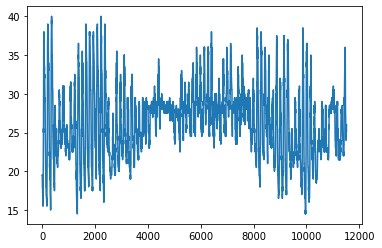

In [332]:
y_pred_result = ((Y_pred*2).astype('int32'))/2

plt.plot(y_pred_result)

y_pred_result = pd.DataFrame(y_pred_result, index = test_dt.index, columns = ['Y18'])

y_pred_result.to_csv('/content/gdrive/My Drive/Colab Notebooks/y_pred_result1.csv')

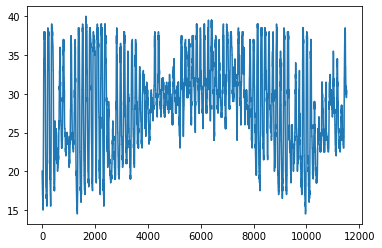

In [325]:
y_pred_result = ((Y_pred*2).astype('int32'))/2

plt.plot(y_pred_result)

y_pred_result = pd.DataFrame(y_pred_result, index = test_dt.index, columns = ['Y18'])

y_pred_result.to_csv('/content/gdrive/My Drive/Colab Notebooks/y_pred_result.csv')

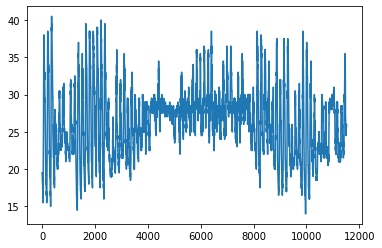

In [260]:
y_pred_result = ((Y_pred*2).astype('int32'))/2

plt.plot(y_pred_result)

y_pred_result = pd.DataFrame(y_pred_result, index = test_dt.index, columns = ['Y18'])

y_pred_result.to_csv('/content/gdrive/My Drive/Colab Notebooks/y_pred_result2.csv')